<a href="https://colab.research.google.com/github/JacekPardyak/tb-data-science-talks/blob/master/2022-03-31/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malicious domain names detection with H2O
## Setting up the workbench

In [ ]:
print('Installing python library...')
!pip install h2o
from __future__ import division
import h2o
print('Starting the server...')
h2o.init()
print('Importing domains data...')
!wget --continue https://github.com/h2oai/app-malicious-domains/raw/master/legit-dga_domains.csv  -O /tmp/legit-dga_domains.csv
domains = h2o.import_file('/tmp/legit-dga_domains.csv', header=1)

Installing python library...
Starting the server...
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,12 mins 02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_unknownUser_xip4mk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.045 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Importing domains data...
--2022-03-17 14:05:38--  https://github.com/h2oai/app-malicious-domains/raw/master/legit-dga_domains.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/h2oai/app-malicious-domains/master/legit-dga_domains.csv [following]
--2022-03-17 14:05:38--  https://raw.githubusercontent.com/h2oai/app-malicious-domains/master/legit-dga_domains.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Problem understanding
The application classifies domain names as legitimate or malicious. Malicious domains earn their label by engaging in malicious activity, such as botnets, phishing, and malware hosting. In order to defeat security systems, attackers use domain names that are generated by algorithms. To detect domains which may be malicious, the app builds a model based on linguistic features that distinguish regular domains from those that are algorithmically generated.

## Data understang

In [ ]:
print('Checking number of rows and columns in the data table ...')
print(domains.shape)

Checking number of rows and columns in the data table ...
(133926, 4)


In [ ]:
print('Printing the head of the data table ...')
domains

Printing the head of the data table ...


host,domain,class,subclass
000directory.com.ar,000directory,legit,legit
000webhost.com,000webhost,legit,legit
001fans.com,001fans,legit,legit
01-telecharger.com,01-telecharger,legit,legit
010shangpu.com,010shangpu,legit,legit
011info.com,011info,legit,legit
0126wyt.com,0126wyt,legit,legit
012global.com,012global,legit,legit
01basma.com,01basma,legit,legit
01webdirectory.com,01webdirectory,legit,legit


In [ ]:
print('Counting domain names classes ...')
domains["class"].table()

Counting domain names classes ...


class,Count
dga,52665
legit,81261


In [ ]:
print('Few legit examples ...')
domains[domains["class"] == 'legit']

Few legit examples ...


host,domain,class,subclass
000directory.com.ar,000directory,legit,legit
000webhost.com,000webhost,legit,legit
001fans.com,001fans,legit,legit
01-telecharger.com,01-telecharger,legit,legit
010shangpu.com,010shangpu,legit,legit
011info.com,011info,legit,legit
0126wyt.com,0126wyt,legit,legit
012global.com,012global,legit,legit
01basma.com,01basma,legit,legit
01webdirectory.com,01webdirectory,legit,legit


In [ ]:
print('Few illegit examples ...')
domains[domains["class"] == 'dga']

Few illegit examples ...


host,domain,class,subclass
1002n0q11m17h017r1shexghfqf.net,1002n0q11m17h017r1shexghfqf,dga,newgoz
1002ra86698fjpgqke1cdvbk5.org,1002ra86698fjpgqke1cdvbk5,dga,newgoz
1008bnt1iekzdt1fqjb76pijxhr.org,1008bnt1iekzdt1fqjb76pijxhr,dga,newgoz
100f3a11ckgv438fpjz91idu2ag.net,100f3a11ckgv438fpjz91idu2ag,dga,newgoz
100fjpj1yk5l751n4g9p01bgkmaf.net,100fjpj1yk5l751n4g9p01bgkmaf,dga,newgoz
100nio91ra2kuteap7eh1o1qk69.net,100nio91ra2kuteap7eh1o1qk69,dga,newgoz
100r9f610d213g1tqlur91h5idd0.net,100r9f610d213g1tqlur91h5idd0,dga,newgoz
100v7dj3vxxrv93ivkol76mbm.net,100v7dj3vxxrv93ivkol76mbm,dga,newgoz
1012ncvpnbc9yz9sbtxdwce6x.net,1012ncvpnbc9yz9sbtxdwce6x,dga,newgoz
1016dgz1it8oyricxmwd14t22e3.net,1016dgz1it8oyricxmwd14t22e3,dga,newgoz


## Data preparation

In [ ]:
print('Data cleaning...')
domains = domains[~domains['subclass'].isna()]
print(domains.shape)
domains

Data cleaning...
(133926, 4)


host,domain,class,subclass
000directory.com.ar,000directory,legit,legit
000webhost.com,000webhost,legit,legit
001fans.com,001fans,legit,legit
01-telecharger.com,01-telecharger,legit,legit
010shangpu.com,010shangpu,legit,legit
011info.com,011info,legit,legit
0126wyt.com,0126wyt,legit,legit
012global.com,012global,legit,legit
01basma.com,01basma,legit,legit
01webdirectory.com,01webdirectory,legit,legit


In [ ]:
print('Adding feature: string length')
domains['length'] = domains['domain'].nchar()
domains

Adding feature: string length


host,domain,class,subclass,length
000directory.com.ar,000directory,legit,legit,12
000webhost.com,000webhost,legit,legit,10
001fans.com,001fans,legit,legit,7
01-telecharger.com,01-telecharger,legit,legit,14
010shangpu.com,010shangpu,legit,legit,10
011info.com,011info,legit,legit,7
0126wyt.com,0126wyt,legit,legit,7
012global.com,012global,legit,legit,9
01basma.com,01basma,legit,legit,7
01webdirectory.com,01webdirectory,legit,legit,14


In [ ]:
print('Adding feature: Shannon entropy')
domains['entropy'] = domains['domain'].entropy()
domains

Adding feature: Shannon entropy


host,domain,class,subclass,length,entropy
000directory.com.ar,000directory,legit,legit,12,3.02206
000webhost.com,000webhost,legit,legit,10,2.84644
001fans.com,001fans,legit,legit,7,2.52164
01-telecharger.com,01-telecharger,legit,legit,14,3.32486
010shangpu.com,010shangpu,legit,legit,10,3.12193
011info.com,011info,legit,legit,7,2.52164
0126wyt.com,0126wyt,legit,legit,7,2.80735
012global.com,012global,legit,legit,9,2.9477
01basma.com,01basma,legit,legit,7,2.52164
01webdirectory.com,01webdirectory,legit,legit,14,3.52164


In [ ]:
print('Adding feature: count vowels')
domains['p_vowels'] = 0
for v in 'aeiou':
  domains['p_vowels'] += domains['domain'].countmatches(v)
domains

Adding feature: count vowels


host,domain,class,subclass,length,entropy,p_vowels
000directory.com.ar,000directory,legit,legit,12,3.02206,3
000webhost.com,000webhost,legit,legit,10,2.84644,2
001fans.com,001fans,legit,legit,7,2.52164,1
01-telecharger.com,01-telecharger,legit,legit,14,3.32486,4
010shangpu.com,010shangpu,legit,legit,10,3.12193,2
011info.com,011info,legit,legit,7,2.52164,2
0126wyt.com,0126wyt,legit,legit,7,2.80735,0
012global.com,012global,legit,legit,9,2.9477,2
01basma.com,01basma,legit,legit,7,2.52164,2
01webdirectory.com,01webdirectory,legit,legit,14,3.52164,4


In [ ]:
print('Mutate feature: calculate proportion of vowels')
domains['p_vowels'] /= domains['length']
domains

Mutate feature: calculate proportion of vowels


host,domain,class,subclass,length,entropy,p_vowels
000directory.com.ar,000directory,legit,legit,12,3.02206,0.25
000webhost.com,000webhost,legit,legit,10,2.84644,0.2
001fans.com,001fans,legit,legit,7,2.52164,0.142857
01-telecharger.com,01-telecharger,legit,legit,14,3.32486,0.285714
010shangpu.com,010shangpu,legit,legit,10,3.12193,0.2
011info.com,011info,legit,legit,7,2.52164,0.285714
0126wyt.com,0126wyt,legit,legit,7,2.80735,0
012global.com,012global,legit,legit,9,2.9477,0.222222
01basma.com,01basma,legit,legit,7,2.52164,0.285714
01webdirectory.com,01webdirectory,legit,legit,14,3.52164,0.285714


In [ ]:
print('Adding feature: count of substrings that are English words')
!wget --continue https://github.com/h2oai/app-malicious-domains/raw/master/src/main/resources/words.txt  -O /tmp/words.txt
english_words = '/tmp/words.txt'
domains['num_words'] = domains['domain'].num_valid_substrings(english_words)
domains
print("Let's check the word list just out of curiosity")
h2o.import_file('/tmp/words.txt')

Adding feature: count of substrings that are English words
--2022-03-17 14:06:09--  https://github.com/h2oai/app-malicious-domains/raw/master/src/main/resources/words.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/h2oai/app-malicious-domains/master/src/main/resources/words.txt [following]
--2022-03-17 14:06:09--  https://raw.githubusercontent.com/h2oai/app-malicious-domains/master/src/main/resources/words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Let's check the word list just out of curiosity
Parse progress: |██

C1
&c
'd
'em
'll
'm
'mid
'midst
'mongst
'prentice
're


In [ ]:
print('Mutate feature (Response) : Is domain malicious?')
domains['class'] = domains['class'] != 'legit'
print('Change Response in data from Boolean to Factor data type')
domains["class"] = domains["class"].asfactor()
domains

Mutate feature (Response) : Is domain malicious?
Change Response in data from Boolean to Factor data type


host,domain,class,subclass,length,entropy,p_vowels,num_words
000directory.com.ar,000directory,0,legit,12,3.02206,0.25,22
000webhost.com,000webhost,0,legit,10,2.84644,0.2,6
001fans.com,001fans,0,legit,7,2.52164,0.142857,6
01-telecharger.com,01-telecharger,0,legit,14,3.32486,0.285714,21
010shangpu.com,010shangpu,0,legit,10,3.12193,0.2,10
011info.com,011info,0,legit,7,2.52164,0.285714,4
0126wyt.com,0126wyt,0,legit,7,2.80735,0,2
012global.com,012global,0,legit,9,2.9477,0.222222,11
01basma.com,01basma,0,legit,7,2.52164,0.285714,6
01webdirectory.com,01webdirectory,0,legit,14,3.52164,0.285714,25


## Train and evaluate models
We use portion of data to train model and the rest to validate model performance. 
First algorithm we gonna use is *Logistic regression with regularization*. Details: 
https://en.wikipedia.org/wiki/Logistic_regression

In [ ]:
print('Split data into train and validation subsets')
rand = domains.runif(seed=123456)
train = domains[rand <= 0.8]
valid = domains[rand > 0.8]
print(train.shape[0] / (train.shape[0] + valid.shape[0])) 

Split data into train and validation subsets
0.8014351208876543


In [ ]:
print('Define model: Logistic regression with regularization')
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

model_lr = H2OGeneralizedLinearEstimator(model_id = 'MaliciousDomainModel',
                                      family = 'binomial', 
                                      alpha = 0, 
                                      lambda_ = 1e-5)

Define model: Logistic regression with regularization


In [ ]:
print('Train model')
model_lr.train(x = ['length', 'entropy', 'p_vowels', 'num_words'],
            y = 'class', 
            training_frame = train, 
            validation_frame = valid)

Train model
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  MaliciousDomainModel


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 1.0E-5 ),4,4,8,py_54_sid_bea2




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.018917779312684666
RMSE: 0.13754191838375915
LogLoss: 0.07117570754925572
Null degrees of freedom: 107332
Residual degrees of freedom: 107328
Null deviance: 143903.13464468886
Residual deviance: 15282.01419075693
AIC: 15292.01419075693
AUC: 0.9964935989895852
AUCPR: 0.9942407381710108
Gini: 0.9929871979791705

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49398253565130285: 


,,0,1,Error,Rate
0,0,63828.0,1252.0,0.0192,(1252.0/65080.0)
1,1,1323.0,40930.0,0.0313,(1323.0/42253.0)
2,Total,65151.0,42182.0,0.024,(2575.0/107333.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.493983,0.969503,190.0
1,max f2,0.204275,0.976659,274.0
2,max f0point5,0.752693,0.974430,125.0
3,max accuracy,0.503916,0.976019,188.0
4,max precision,0.999990,0.999148,0.0
5,max recall,0.000189,1.000000,398.0
6,max specificity,0.999990,0.999785,0.0
7,max absolute_mcc,0.503916,0.949737,188.0
8,max min_per_class_accuracy,0.412814,0.975268,213.0
9,max mean_per_class_accuracy,0.416973,0.975601,212.0



Gains/Lift Table: Avg response rate: 39.37 %, avg score: 39.38 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010006,1.000000e+00,2.535515,2.535515,0.998138,1.000000,0.998138,1.000000,0.025371,0.025371,153.551522,153.551522,0.025340
1,2,0.020040,1.000000e+00,2.540246,2.537884,1.000000,1.000000,0.999070,1.000000,0.025489,0.050860,154.024566,153.788374,0.050830
2,3,0.030009,1.000000e+00,2.540246,2.538668,1.000000,1.000000,0.999379,1.000000,0.025324,0.076184,154.024566,153.866836,0.076153
3,4,0.040006,1.000000e+00,2.540246,2.539063,1.000000,1.000000,0.999534,1.000000,0.025395,0.101579,154.024566,153.906250,0.101548
4,5,0.050003,1.000000e+00,2.540246,2.539299,1.000000,1.000000,0.999627,1.000000,0.025395,0.126973,154.024566,153.929905,0.126943
5,6,0.100007,1.000000e+00,2.539299,2.539299,0.999627,1.000000,0.999627,1.000000,0.126973,0.253946,153.929905,153.929905,0.253885
6,7,0.150000,9.998900e-01,2.535512,2.538037,0.998136,0.999982,0.999130,0.999994,0.126760,0.380707,153.551170,153.803675,0.380492
7,8,0.200320,9.989008e-01,2.528958,2.535756,0.995556,0.999504,0.998233,0.999871,0.127257,0.507964,152.895777,153.575614,0.507380
8,9,0.300001,9.813411e-01,2.518165,2.529911,0.991308,0.993724,0.995932,0.997828,0.251012,0.758976,151.816483,152.991112,0.756963
9,10,0.400026,3.898440e-01,2.174210,2.440969,0.855905,0.830523,0.960919,0.955994,0.217476,0.976451,117.420989,144.096925,0.950668




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.019500956462740988
RMSE: 0.1396458250816722
LogLoss: 0.0705917384908851
Null degrees of freedom: 26592
Residual degrees of freedom: 26588
Null deviance: 35604.718012293604
Residual deviance: 3754.4922033762136
AIC: 3764.4922033762136
AUC: 0.9965836852378502
AUCPR: 0.9947680076018437
Gini: 0.9931673704757005

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49827790456008814: 


,,0,1,Error,Rate
0,0,15867.0,314.0,0.0194,(314.0/16181.0)
1,1,350.0,10062.0,0.0336,(350.0/10412.0)
2,Total,16217.0,10376.0,0.025,(664.0/26593.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.498278,0.968058,194.0
1,max f2,0.246010,0.975726,260.0
2,max f0point5,0.682998,0.973363,146.0
3,max accuracy,0.498278,0.975031,194.0
4,max precision,0.999997,1.000000,0.0
5,max recall,0.000512,1.000000,396.0
6,max specificity,0.999997,1.000000,0.0
7,max absolute_mcc,0.498278,0.947567,194.0
8,max min_per_class_accuracy,0.381796,0.973796,221.0
9,max mean_per_class_accuracy,0.311647,0.974369,240.0



Gains/Lift Table: Avg response rate: 39.15 %, avg score: 39.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010040,1.000000e+00,2.554072,2.554072,1.000000,1.000000,1.000000,1.000000,0.025643,0.025643,155.407222,155.407222,0.025643
1,2,0.020005,1.000000e+00,2.554072,2.554072,1.000000,1.000000,1.000000,1.000000,0.025451,0.051095,155.407222,155.407222,0.051095
2,3,0.030008,1.000000e+00,2.554072,2.554072,1.000000,1.000000,1.000000,1.000000,0.025547,0.076642,155.407222,155.407222,0.076642
3,4,0.040048,1.000000e+00,2.554072,2.554072,1.000000,1.000000,1.000000,1.000000,0.025643,0.102286,155.407222,155.407222,0.102286
4,5,0.050013,1.000000e+00,2.554072,2.554072,1.000000,1.000000,1.000000,1.000000,0.025451,0.127737,155.407222,155.407222,0.127737
5,6,0.100026,1.000000e+00,2.554072,2.554072,1.000000,1.000000,1.000000,1.000000,0.127737,0.255474,155.407222,155.407222,0.255474
6,7,0.150002,9.998868e-01,2.552150,2.553432,0.999248,0.999982,0.999749,0.999994,0.127545,0.383020,155.215042,155.343195,0.382958
7,8,0.200053,9.988177e-01,2.544478,2.551192,0.996243,0.999481,0.998872,0.999866,0.127353,0.510373,154.447766,155.119169,0.510002
8,9,0.300229,9.813367e-01,2.537774,2.546715,0.993619,0.993477,0.997119,0.997734,0.254226,0.764599,153.777372,154.671455,0.763177
9,10,0.399992,3.437392e-01,2.123740,2.441220,0.831511,0.818480,0.955815,0.953026,0.211871,0.976469,112.374042,144.121955,0.947423




Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-03-17 14:06:26,0.000 sec,0,71951.567322,0.670358,,,,,,,,,,,,,,
1,,2022-03-17 14:06:26,0.125 sec,1,29411.212256,0.274026,,,,,,,,,,,,,,
2,,2022-03-17 14:06:26,0.194 sec,2,18029.919843,0.168010,,,,,,,,,,,,,,
3,,2022-03-17 14:06:26,0.252 sec,3,11634.138841,0.108483,,,,,,,,,,,,,,
4,,2022-03-17 14:06:26,0.275 sec,4,8766.044533,0.081882,,,,,,,,,,,,,,
5,,2022-03-17 14:06:26,0.297 sec,5,7836.541972,0.073370,,,,,,,,,,,,,,
6,,2022-03-17 14:06:26,0.325 sec,6,7644.699875,0.071700,,,,,,,,,,,,,,
7,,2022-03-17 14:06:27,0.515 sec,7,7641.143549,0.071672,,,,,,,,,,,,,,
8,,2022-03-17 14:06:27,0.783 sec,8,7641.007095,0.071671,0.137542,0.071176,0.920744,0.996494,0.994241,2.535515,0.023991,0.139646,0.070592,0.918144,0.996584,0.994768,2.554072,0.024969



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,length,8.201095,1.000000,0.520645
1,num_words,5.097904,0.621613,0.323639
2,entropy,1.300796,0.158612,0.082581
3,p_vowels,1.152013,0.140471,0.073135


Second model using *GradientBoosting* algorithm. Details: https://en.wikipedia.org/wiki/Gradient_boosting

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

print('Split data into train and validation subsets')
rand = domains.runif(seed=123456)
train = domains[rand <= 0.8]
valid = domains[rand > 0.8]
print('Define model: Gradient Boosting')
model_gb = H2OGradientBoostingEstimator(distribution="bernoulli",
                                   ntrees=100,
                                   max_depth=4,
                                   learn_rate=0.1)
print('Train model')
model_gb.train(x = ['length', 'entropy', 'p_vowels', 'num_words'],
            y = 'class', 
            training_frame = train, 
            validation_frame = valid)

Split data into train and validation subsets
Define model: Gradient Boosting
Train model
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1647525212251_24


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,23997.0,4.0,4.0,4.0,9.0,16.0,14.5




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.01005763383495989
RMSE: 0.10028775515963995
LogLoss: 0.03603259232032783
Mean Per-Class Error: 0.013094651062261688
AUC: 0.9991408164905782
AUCPR: 0.9986085814362952
Gini: 0.9982816329811564

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4878842071049424: 


,,0,1,Error,Rate
0,0,64252.0,828.0,0.0127,(828.0/65080.0)
1,1,569.0,41684.0,0.0135,(569.0/42253.0)
2,Total,64821.0,42512.0,0.013,(1397.0/107333.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.487884,0.983519,223.0
1,max f2,0.169765,0.987992,292.0
2,max f0point5,0.864388,0.986094,120.0
3,max accuracy,0.487884,0.986984,223.0
4,max precision,0.999635,1.000000,0.0
5,max recall,0.003190,1.000000,384.0
6,max specificity,0.999635,1.000000,0.0
7,max absolute_mcc,0.487884,0.972777,223.0
8,max min_per_class_accuracy,0.464201,0.986841,228.0
9,max mean_per_class_accuracy,0.487884,0.986905,223.0



Gains/Lift Table: Avg response rate: 39.37 %, avg score: 39.37 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010109,0.999481,2.540246,2.540246,1.000000,0.999616,1.000000,0.999616,0.025679,0.025679,154.024566,154.024566,0.025679
1,2,0.020022,0.999398,2.540246,2.540246,1.000000,0.999425,1.000000,0.999521,0.025182,0.050860,154.024566,154.024566,0.050860
2,3,0.031742,0.999380,2.540246,2.540246,1.000000,0.999382,1.000000,0.999470,0.029773,0.080633,154.024566,154.024566,0.080633
3,4,0.053404,0.999376,2.539153,2.539802,0.999570,0.999376,0.999826,0.999432,0.055002,0.135635,153.915308,153.980249,0.135620
4,5,0.100547,0.999087,2.540246,2.540010,1.000000,0.999276,0.999907,0.999359,0.119755,0.255390,154.024566,154.001028,0.255375
5,6,0.150196,0.998696,2.540246,2.540088,1.000000,0.998894,0.999938,0.999205,0.126121,0.381511,154.024566,154.008809,0.381496
6,7,0.200097,0.998240,2.539771,2.540009,0.999813,0.998490,0.999907,0.999027,0.126737,0.508248,153.977138,154.000911,0.508217
7,8,0.300159,0.992553,2.535752,2.538590,0.998231,0.996364,0.999348,0.998139,0.253733,0.761981,153.575175,153.858986,0.761659
8,9,0.400091,0.330348,2.281627,2.474407,0.898191,0.904043,0.974082,0.974637,0.228007,0.989989,128.162658,147.440738,0.972887
9,10,0.500033,0.002697,0.100170,1.999870,0.039433,0.034217,0.787274,0.786675,0.010011,1.000000,-89.982997,99.986957,0.824570




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.011131954252570814
RMSE: 0.10550807671723911
LogLoss: 0.03994761155569807
Mean Per-Class Error: 0.014444779894975546
AUC: 0.9989232568193517
AUCPR: 0.9982728680399754
Gini: 0.9978465136387034

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40821364490034145: 


,,0,1,Error,Rate
0,0,15928.0,253.0,0.0156,(253.0/16181.0)
1,1,138.0,10274.0,0.0133,(138.0/10412.0)
2,Total,16066.0,10527.0,0.0147,(391.0/26593.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.408214,0.981327,234.0
1,max f2,0.146043,0.986836,299.0
2,max f0point5,0.847376,0.984726,128.0
3,max accuracy,0.413854,0.985297,233.0
4,max precision,0.999631,1.000000,0.0
5,max recall,0.002274,1.000000,388.0
6,max specificity,0.999631,1.000000,0.0
7,max absolute_mcc,0.408214,0.969242,234.0
8,max min_per_class_accuracy,0.446725,0.984859,226.0
9,max mean_per_class_accuracy,0.408214,0.985555,234.0



Gains/Lift Table: Avg response rate: 39.15 %, avg score: 39.17 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010567,0.999521,2.554072,2.554072,1.000000,0.999626,1.000000,0.999626,0.026988,0.026988,155.407222,155.407222,0.026988
1,2,0.020945,0.999398,2.554072,2.554072,1.000000,0.999428,1.000000,0.999528,0.026508,0.053496,155.407222,155.407222,0.053496
2,3,0.033091,0.999380,2.554072,2.554072,1.000000,0.999382,1.000000,0.999475,0.031022,0.084518,155.407222,155.407222,0.084518
3,4,0.055729,0.999376,2.554072,2.554072,1.000000,0.999376,1.000000,0.999435,0.057818,0.142336,155.407222,155.407222,0.142336
4,5,0.100214,0.999087,2.554072,2.554072,1.000000,0.999278,1.000000,0.999365,0.113619,0.255955,155.407222,155.407222,0.255955
5,6,0.150039,0.998693,2.552145,2.553432,0.999245,0.998894,0.999749,0.999209,0.127161,0.383116,155.214462,155.343211,0.383054
6,7,0.201933,0.998168,2.554072,2.553597,1.000000,0.998458,0.999814,0.999016,0.132539,0.515655,155.407222,155.359661,0.515593
7,8,0.300004,0.992005,2.546238,2.551191,0.996933,0.996155,0.998872,0.998080,0.249712,0.765367,154.623765,155.119097,0.764811
8,9,0.399992,0.279772,2.244779,2.474595,0.878902,0.887951,0.968882,0.970551,0.224453,0.989819,124.477878,147.459512,0.969363
9,10,0.500019,0.002730,0.100819,1.999733,0.039474,0.031565,0.782959,0.782711,0.010085,0.999904,-89.918136,99.973272,0.821547




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-03-17 14:06:33,0.046 sec,0.0,0.488562,0.670358,0.500000,0.393663,1.000000,0.606337,0.488097,0.669438,0.500000,0.391532,1.000000,0.608468
1,,2022-03-17 14:06:34,0.307 sec,1.0,0.444400,0.584537,0.992742,0.987683,2.533855,0.025929,0.444179,0.584143,0.992270,0.986618,2.544830,0.027488
2,,2022-03-17 14:06:34,0.485 sec,2.0,0.405874,0.515903,0.995529,0.992964,2.537028,0.022062,0.405805,0.515788,0.995378,0.992696,2.551215,0.023578
3,,2022-03-17 14:06:34,0.637 sec,3.0,0.370309,0.456772,0.996309,0.993890,2.537028,0.021419,0.370468,0.457000,0.996126,0.993561,2.551215,0.023540
4,,2022-03-17 14:06:34,0.771 sec,4.0,0.338855,0.407252,0.996410,0.994052,2.537538,0.020953,0.339261,0.407797,0.996257,0.993709,2.550559,0.022976
5,,2022-03-17 14:06:34,0.958 sec,5.0,0.311039,0.365217,0.996317,0.993720,2.535008,0.020143,0.311692,0.366028,0.996182,0.993398,2.547351,0.022261
6,,2022-03-17 14:06:34,1.114 sec,6.0,0.286501,0.329283,0.996334,0.993738,2.535008,0.019938,0.287398,0.330319,0.996200,0.993422,2.547351,0.022036
7,,2022-03-17 14:06:35,1.276 sec,7.0,0.265693,0.299486,0.996613,0.994336,2.535008,0.019985,0.266836,0.300722,0.996479,0.994045,2.547351,0.021885
8,,2022-03-17 14:06:35,1.482 sec,8.0,0.246442,0.272305,0.996642,0.994399,2.535008,0.019435,0.247836,0.273717,0.996517,0.994135,2.547351,0.021885
9,,2022-03-17 14:06:35,1.662 sec,9.0,0.229690,0.248851,0.997076,0.995506,2.538910,0.019472,0.231173,0.250259,0.996977,0.995507,2.554072,0.021961



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,p_vowels,70480.156250,1.000000,0.538564
1,length,33119.019531,0.469906,0.253074
2,num_words,21387.580078,0.303455,0.163430
3,entropy,5880.116699,0.083429,0.044932


## Explaining the model

Explaining the result obtained becomes more difficult the more complicated the algorithm we use. In the case of neural networks it is impossible, but the model works :) like hell. 

In [ ]:
print('Predicting Response using model_lr and model_gb models')

test = h2o.H2OFrame([["03111976"], ["jacekpardyak"], ["1002ra86698fjpgqke1cdvbk5"]])
test.col_names = ["domain"]
test['length'] = test['domain'].nchar()
test['entropy'] = test['domain'].entropy()
test['p_vowels'] = 0
for v in 'aeiou':
  test['p_vowels'] += test['domain'].countmatches(v)
test['num_words'] = test['domain'].num_valid_substrings(english_words)
test

print(model_lr.predict(test))
print(model_gb.predict(test))

Predicting Response using model_lr and model_gb models
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.0234691,0.976531
0,1,1.09472e-15
1,4.47918e-06,0.999996



gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.999996,4.33747e-06
0,0.955635,0.0443649
1,0.0109651,0.989035


Explain a model


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## MaliciousDomainModel


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49827790456008814: 


,,0,1,Error,Rate
0,0,15867.0,314.0,0.0194,(314.0/16181.0)
1,1,350.0,10062.0,0.0336,(350.0/10412.0)
2,Total,16217.0,10376.0,0.025,(664.0/26593.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

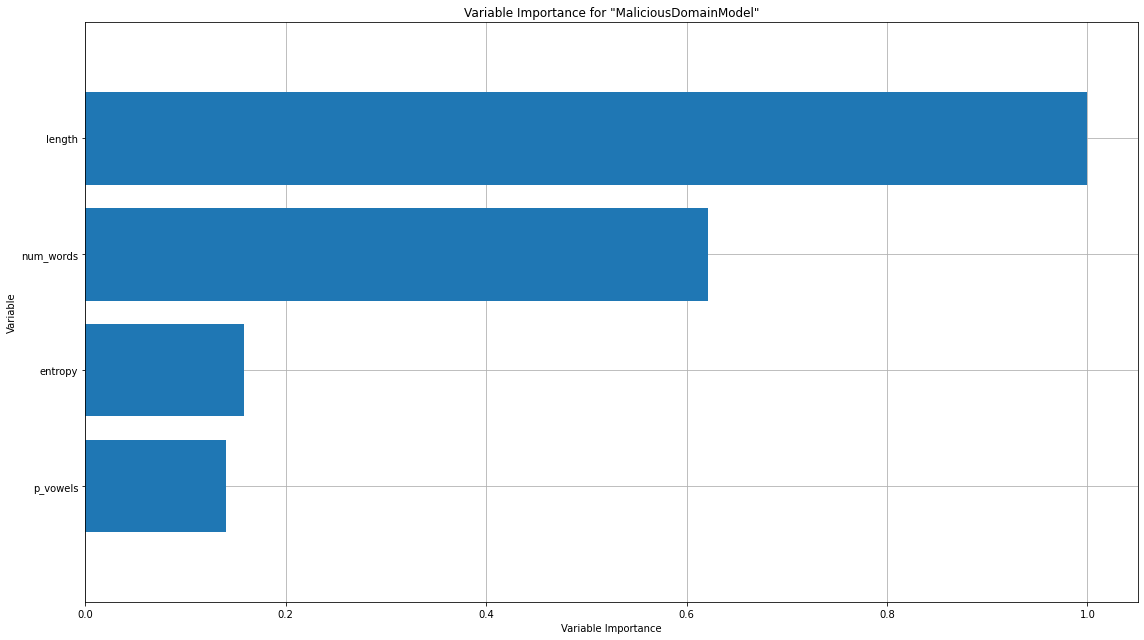

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

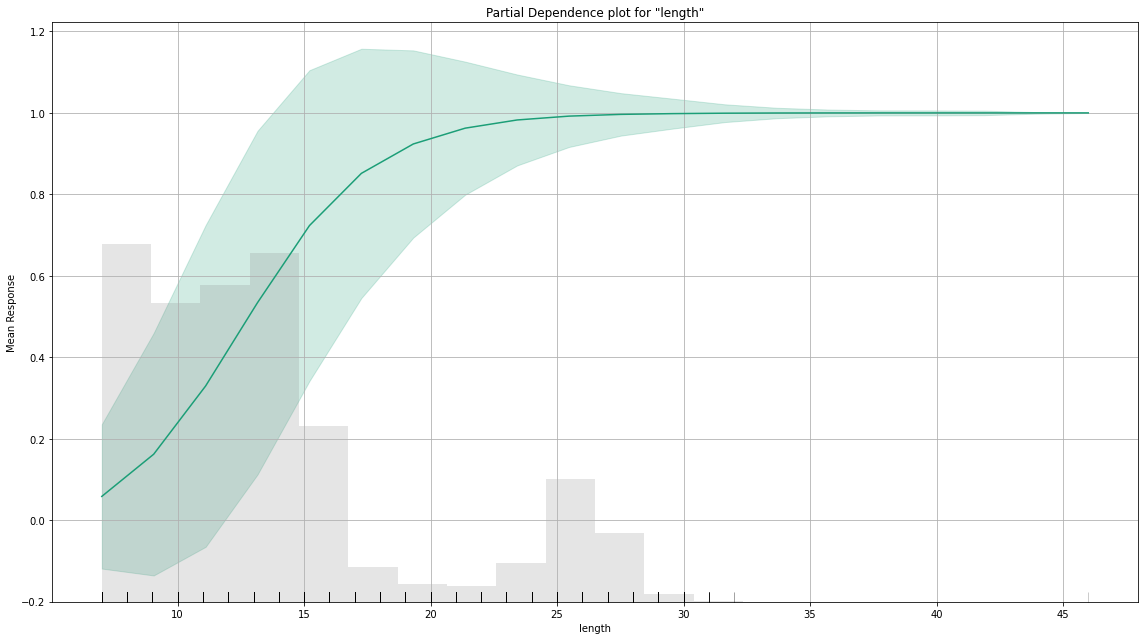

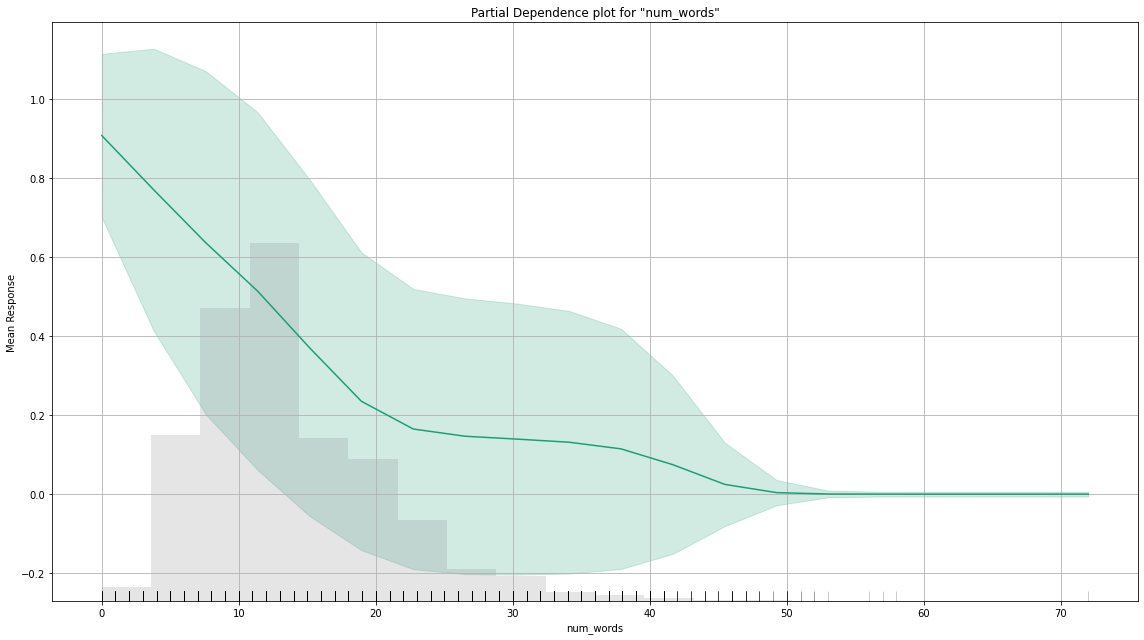

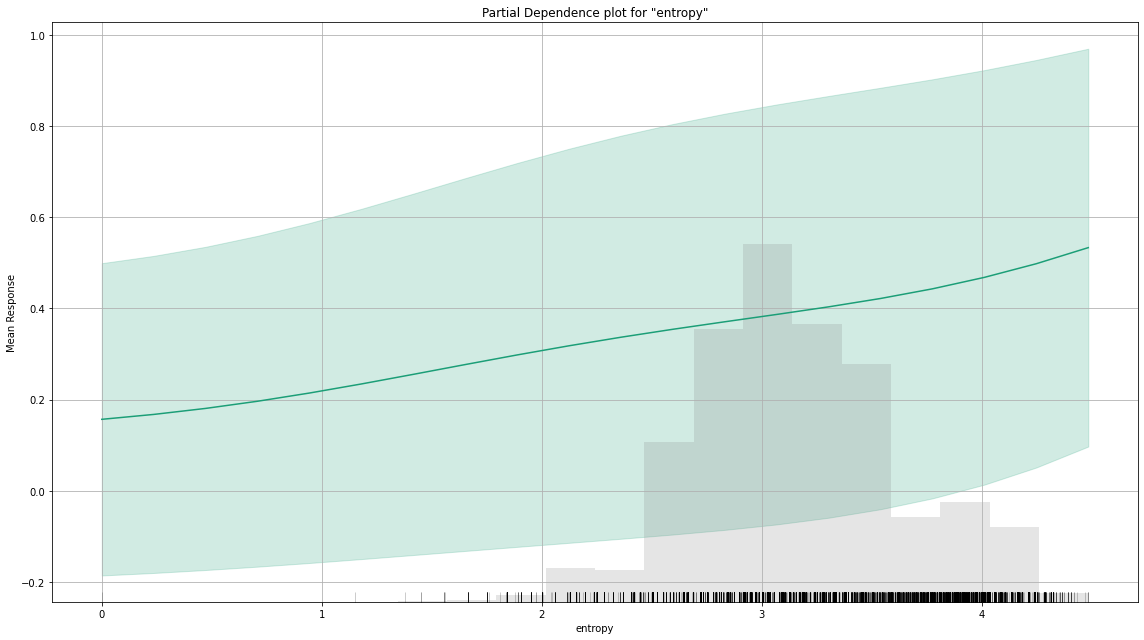

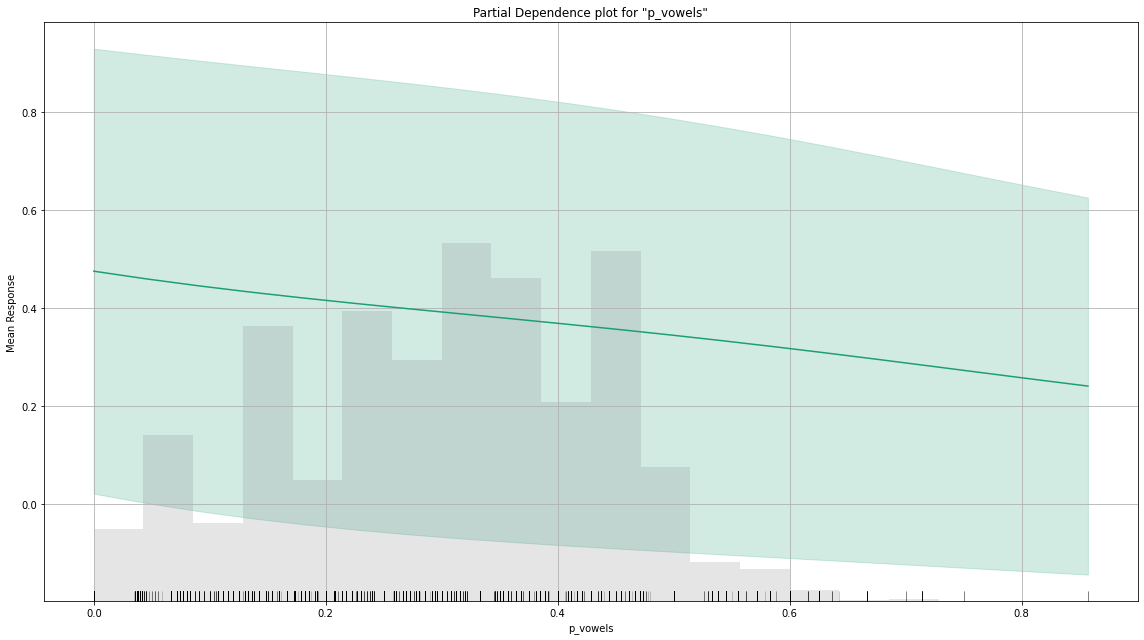

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## MaliciousDomainModel


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49827790456008814: 


,,0,1,Error,Rate
0,0,15867.0,314.0,0.0194,(314.0/16181.0)
1,1,350.0,10062.0,0.0336,(350.0/10412.0)
2,Total,16217.0,10376.0,0.025,(664.0/26593.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [ ]:
print('Explain a model')
model_lr.explain(valid)

We can also plot trees produces by the second - Gradient Boosting algorithm.

In [ ]:
# set the environment
!sudo apt-get install graphviz
!wget --continue https://h2o-release.s3.amazonaws.com/h2o/rel-zorn/3/h2o-3.36.0.3.zip -O /tmp/h2o-3.36.0.3.zip
%cd /tmp/
!unzip h2o-3.36.0.3.zip
%cd h2o-3.36.0.3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
--2022-03-17 14:33:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-zorn/3/h2o-3.36.0.3.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.135.161
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.135.161|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

/tmp
Archive:  h2o-3.36.0.3.zip
replace h2o-3.36.0.3/R/h2o_client_3.36.0.3.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/tmp/h2o-3.36.0.3


In [ ]:
# save the model
modelfile = model_gb.download_mojo(path="/tmp", get_genmodel_jar=True)
print("Model saved to " + modelfile)


Model saved to /tmp/GBM_model_python_1647525212251_24.zip


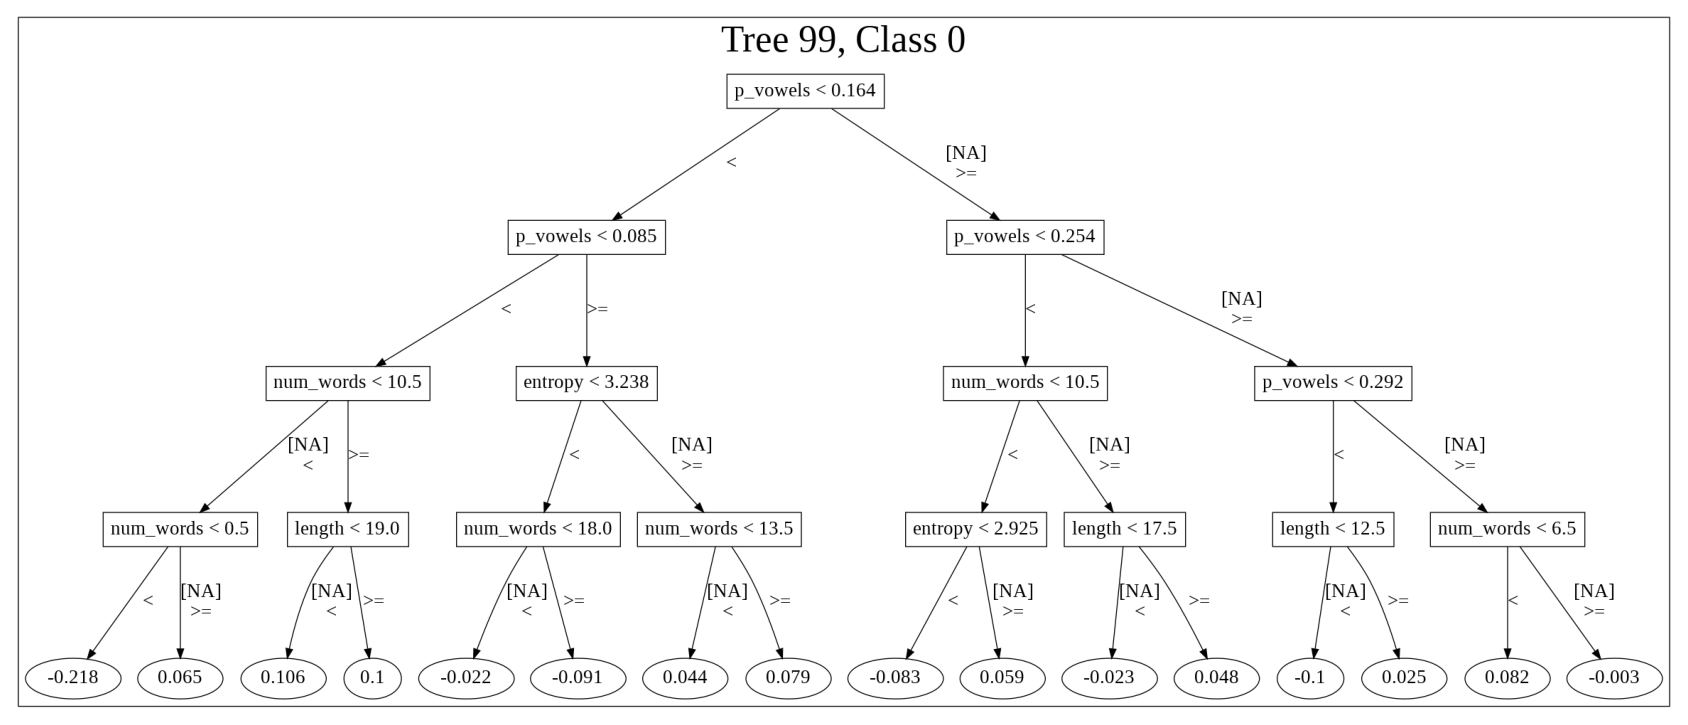

In [ ]:
# print model as Graphviz Dot File and convert ito png and svg format
# you need to change archive in the line below to 'modelfile' you have just created
!java -cp h2o.jar hex.genmodel.tools.PrintMojo --tree 99 -i /tmp/GBM_model_python_1647525212251_24.zip -o /tmp/model.gv -f 20 -d 3
!dot -Tpng /tmp/model.gv -o /tmp/model.png
!dot -Tsvg /tmp/model.gv -o /tmp/model.svg

# plot our tree
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [30, 30]
plt.axis('off')
img = mpimg.imread("/tmp/model.png")
plt.imshow(img)
plt.show()

## Model deployment

This is a hypothetical scenario where we want to "plug" our model into an existing workflow using java.

In [ ]:
test

domain,length,entropy,p_vowels,num_words
03111976,8,2.40564,0,0
jacekpardyak,12,3.02206,4,15
1002ra86698fjpgqke1cdvbk5,25,4.24386,2,5


In [ ]:
java_code = """
import java.io.*;
import hex.genmodel.easy.RowData;
import hex.genmodel.easy.EasyPredictModelWrapper;
import hex.genmodel.easy.prediction.*;
import hex.genmodel.MojoModel;

public class main {
  public static void main(String[] args) throws Exception {
    EasyPredictModelWrapper model = new EasyPredictModelWrapper(MojoModel.load("%s"));

    RowData row = new RowData();
    row.put("length", "12");
    row.put("entropy", "3.02206");
    row.put("p_vowels", "4");
    row.put("num_words", "15");

    BinomialModelPrediction p = model.predictBinomial(row);
    System.out.println("Domain is malicious (0=no; 1=yes): " + p.label);
    System.out.print("Class probabilities: ");
    for (int i = 0; i < p.classProbabilities.length; i++) {
      if (i > 0) {
    System.out.print(",");
      }
      System.out.print(p.classProbabilities[i]);
    }
    System.out.println("");
  }
}
"""
java_code = java_code % modelfile

with open("/tmp/main.java",'w',encoding = 'utf-8') as f:
   f.write(java_code)
# check if file created
%cd /tmp
!ls   

/tmp
dap_multiplexer.eb81d884bc3a.root.log.INFO.20220317-134754.44
dap_multiplexer.INFO
debugger_1mlb6p013o
GBM_model_python_1647525212251_24.zip
h2o-3.36.0.3
h2o-3.36.0.3.zip
h2o-genmodel.jar
hsperfdata_root
initgoogle_syslog_dir.0
legit-dga_domains.csv
libxgboost4j_gpu1322126483980810599.so
main.class
main.java
model.gv
model.png
model.svg
pyright-219-btHwJPkcolwE
pyright-219-PNkDkMZ4Zamd
pyright-475-GPUPfa663PUb
pyright-475-s7CM59DyY0qD
pyright-98-hB9539q9f5zF
pyright-98-MaluFN6IT39a
python-languageserver-cancellation
tmp64fwrlr8
words.txt


In [ ]:
# compile java program
!javac -cp h2o-genmodel.jar -J-Xms2g main.java

In [ ]:
# run the program
!java -cp .:h2o-genmodel.jar main

Domain is malicious (0=no; 1=yes): 0
Class probabilities: 0.9556351320759139,0.04436486792408611


In [ ]:
h2o.cluster().shutdown()

## Try yourself:

- "Explain" Gradient Boosting model with `explain()` function

- Hack the model - try to find a domain name for you definitely malicious but not for the model (model predicting response 0)

- Train models with H2O’s AutoML. You can start from **cell** below. Watch out - it takes time to complete :)



In [ ]:
# H2OAutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. 
#from h2o.automl import H2OAutoML

#train = domains

# Identify predictors and response
#x = ['length', 'entropy', 'p_vowels', 'num_words']
#y = "class"

# Run AutoML for 20 base models
#aml = H2OAutoML(max_models=20, seed=1)
#aml.train(x = x, 
#          y = y, 
#          training_frame = train)

# View the AutoML Leaderboard
#lb = aml.leaderboard
#lb.head(rows = lb.nrows)  # Print all rows instead of default (10 rows)

## References
 https://github.com/h2oai/app-malicious-domains